<a href="https://colab.research.google.com/github/Dcrawf/Deep-Dive-Final/blob/master/DeepDiveFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Deep Dive

---


Deep Dive is the product of my exploration of Google's Deep Dream program. It is built off the existing Deep Dream code by Alex Mordvintsev, and uses the Inception trained model. Each code cell must be run in order. You can either run them all by hand, by pressing the play button on the top left corner of each code cell, or you may press ctrl+f9 to run them all.


Download the Inception model from Google.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip
!wget https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
with open('pilatus800.jpg','rb') as f:
  file_contents = f.read()
print("Inception model downloaded.")

--2019-04-22 19:34:40--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 2607:f8b0:4001:c19::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  19.6MB/s    in 2.4s    

2019-04-22 19:34:42 (19.6 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
--2019-04-22 19:34:43--  https://github.com/tensorflow/tensorflow/raw/master/tensorflow/examples/tutorials/deepdream/pilatus800.jpg
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443..

In [0]:
from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
from __future__ import print_function


# https://github.com/Dcrawf/Deep-Dive-Assets
# https://github.com/ProGamerGov/Protobuf-Dreamer
# https://github.com/ProGamerGov/Protobuf-Dreamer/wiki/Interesting-Layers-And-Channels
# http://storage.googleapis.com/deepdream/visualz/tensorflow_inception/index.html


  
# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0
    
# Create tensorflow session
model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
# Then initialize graph using graph() function of TensorFlow
graph = tf.Graph()
# Initialize a session using the graph
sess = tf.InteractiveSession(graph=graph)
# Open existing saved in-session graph
with tf.gfile.GFile(model_fn, 'rb') as f:
  # Once we open it, we can read the graph and parse it
  graph_def = tf.GraphDef()
  # Using the ParseFromString() method of TensorFlow
  graph_def.ParseFromString(f.read())
  # We need to define out input so we create an input tensor using the placeholder() method
  # Called input with the size of 32 bits
t_input = tf.placeholder(np.float32, name='input')
# Then we define image net mean value of pixels in an image as 117
imagenet_mean = 117.0
# We subtract it from the input tensor and store it in the preprocessed variable
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
# Then load the graph_def variable we initialized as the newly processed tensor
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

  

**Please only upload .jpg files for now**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dreamed.jpg to dreamed.jpg


In [0]:
if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[list(uploaded.keys())[0]]

# Show the Image Before the DeepDream

Instructions for updating:
Colocations handled automatically by placer.


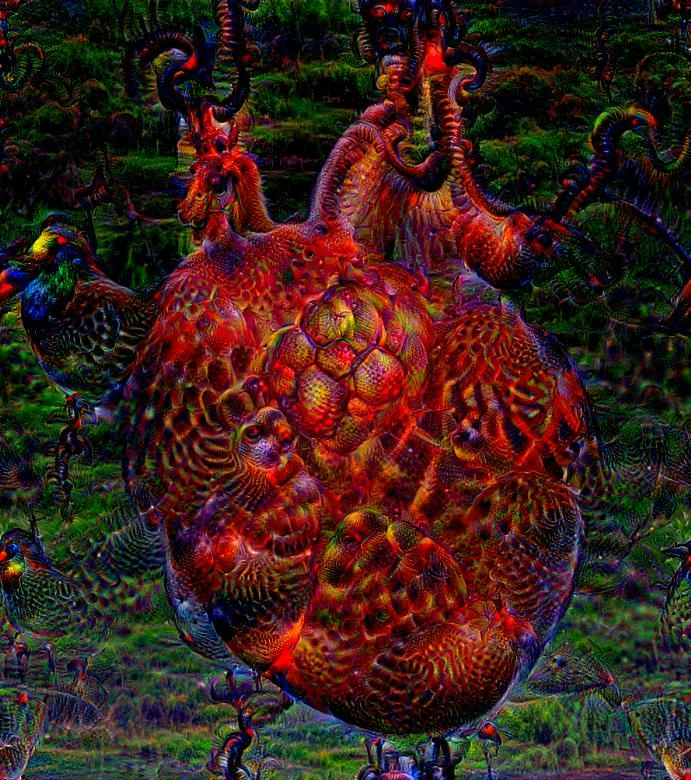

In [5]:
def showarray(a, fmt="jpeg"):
    # Ensure the pixel-values are between 0 and 255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)

In [0]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a series of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img
  
  

# Output Image

---


*   Octave: The input image is  downscaled, and gradient ascent is applied to all the images, and then the result is merged into the final image
*   Octave scale: Relative scale the ascent is applied to
*   Iteration: How many images are in the feedback loop
*   Strength: How strongly the DeepDream is applied to the image
*   Layer: Reference to a tensor that will be maximized



**After making changes to the slider, please press the play button again to apply changes to your image.**




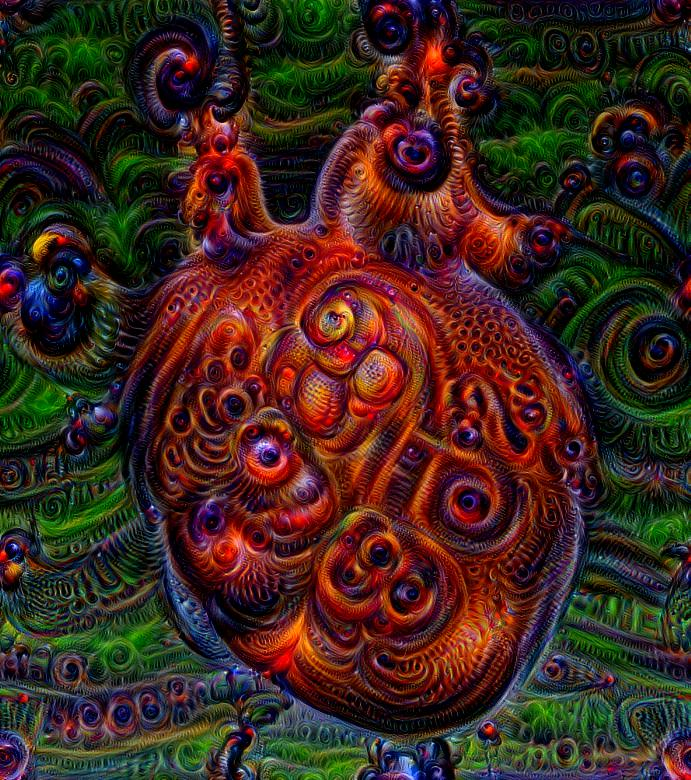

In [9]:
octave_n = 4 #@param {type:"slider", max: 10}
octave_scale = 2 #@param {type:"number"}
iter_n = 14 #@param {type:"slider", max: 50}
strength = 252 #@param {type:"slider", max: 1000}
layer = "mixed3b"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img0)
